### 📚 Import and Libraries

In [55]:
import pandas as pd
import numpy as np

import pm4py
from pm4py.algo.filtering.log.timestamp.timestamp_filter import filter_traces_contained
from pm4py.algo.evaluation.generalization import algorithm as generalization_evaluator
from pm4py.algo.evaluation.simplicity import algorithm as simplicity_evaluator
from pm4py.algo.evaluation.precision import algorithm as precision_evaluator
from pm4py.algo.discovery.heuristics import algorithm as heuristics_miner
from pm4py.algo.analysis.woflan import algorithm as woflan


import matplotlib.pyplot as plt
import seaborn as sns
from prettytable import PrettyTable

### 🧠 Data Understanding

The dataset consists of 238,722 observations, categorized into three key variables that have been carefully selected and derived from the original dataset: TR_TS_CREATION, BRANCH_ORDER_ID, and ACTIVITY.
<br />
<br />
The TR_TS_CREATION represents the timestamp indicating when a cash demand order was created for a specific bank branch. Next, the BRANCH_ORDER_ID serves as the unique identifier assigned to each order. Finally, the ACTIVITY feature captures the various states an order can assume throughout its lifecycle.

In [11]:
df = pd.read_csv("./data/data.csv", sep=";", parse_dates=['TR_TS_CREATION'], dtype={'ACTIVITY': 'str', 'BRANCH_ORDER_ID': 'str'})
df.drop_duplicates(inplace=True)
df

,TR_TS_CREATION,BRANCH_ORDER_ID,ACTIVITY
0,2021-07-19 17:30:36.410000000,1,ADDED
1,2021-07-20 08:20:36.336666700,1,AUTHORIZED
3,2021-07-21 14:52:23.116666700,6,ADDED
4,2021-07-21 14:53:18.810000000,6,AUTHORIZED
5,2021-07-21 16:09:10.850000000,7,ADDED
...,...,...,...
238717,2025-02-12 12:54:27.666666700,67426,CLOSED
238718,2025-02-12 12:58:22.773000000,67357,CLOSED
238719,2025-02-12 12:58:22.786666700,67357,CLOSED
238720,2025-02-12 13:05:56.742000000,67385,CLOSED


In [12]:
log = pm4py.format_dataframe(df.sort_values(by=['BRANCH_ORDER_ID', 'TR_TS_CREATION']), case_id='BRANCH_ORDER_ID', activity_key='ACTIVITY', timestamp_key='TR_TS_CREATION')
log

,TR_TS_CREATION,BRANCH_ORDER_ID,ACTIVITY,case:concept:name,concept:name,time:timestamp,@@index,@@case_index
0,2021-07-19 17:30:36.410000+00:00,1,ADDED,1,ADDED,2021-07-19 17:30:36.410000+00:00,0,0
1,2021-07-20 08:20:36.336666700+00:00,1,AUTHORIZED,1,AUTHORIZED,2021-07-20 08:20:36.336666700+00:00,1,0
2,2021-07-22 10:37:57.650000+00:00,10,ADDED,10,ADDED,2021-07-22 10:37:57.650000+00:00,2,1
3,2021-07-22 11:38:59.260000+00:00,10,AUTHORIZED,10,AUTHORIZED,2021-07-22 11:38:59.260000+00:00,3,1
4,2021-07-22 18:29:59.520000+00:00,10,CONFIRMED_BY_CIT,10,CONFIRMED_BY_CIT,2021-07-22 18:29:59.520000+00:00,4,1
...,...,...,...,...,...,...,...,...
235954,2021-10-11 10:20:16.170000+00:00,98,CLOSED,98,CLOSED,2021-10-11 10:20:16.170000+00:00,235954,57296
235955,2021-10-05 19:19:52.063333300+00:00,99,ADDED,99,ADDED,2021-10-05 19:19:52.063333300+00:00,235955,57297
235956,2021-10-06 10:39:48.986666700+00:00,99,AUTHORIZED,99,AUTHORIZED,2021-10-06 10:39:48.986666700+00:00,235956,57297
235957,2021-10-06 13:19:31.093333300+00:00,99,CONFIRMED_BY_CIT,99,CONFIRMED_BY_CIT,2021-10-06 13:19:31.093333300+00:00,235957,57297


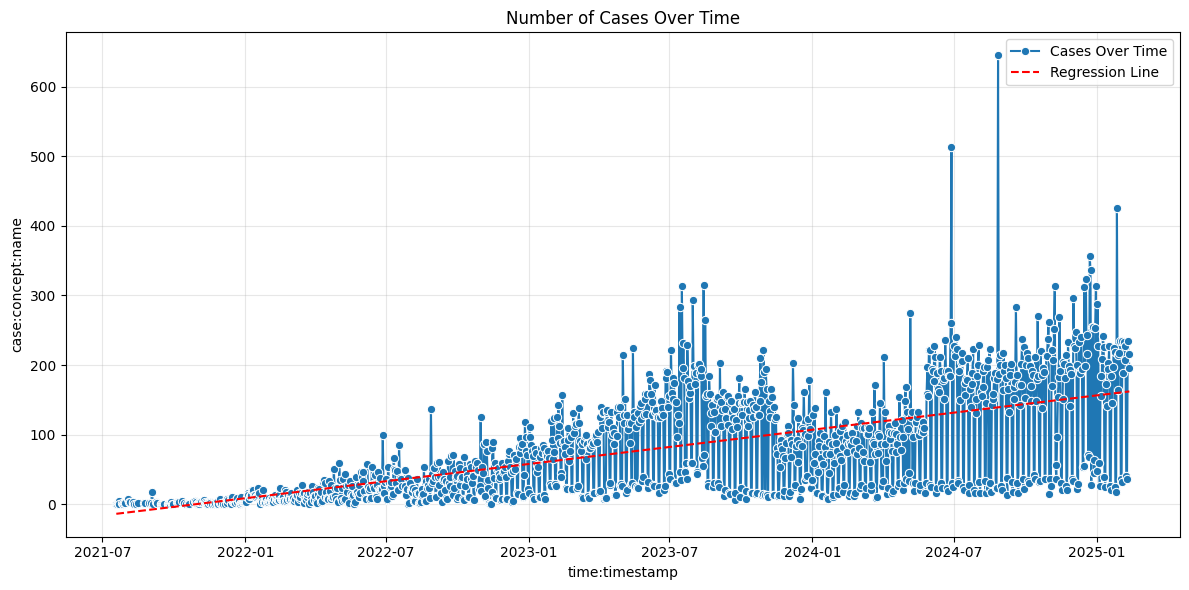

In [13]:
# Group by date and count unique cases
df_cases_over_time = log.groupby(log['time:timestamp'].dt.date)['@@case_index'].nunique().reset_index()
df_cases_over_time.columns = ['date', 'num_cases']
df_cases_over_time['date_numeric'] = pd.to_datetime(df_cases_over_time['date']).map(pd.Timestamp.toordinal)

# Create the original line plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_cases_over_time, x='date', y='num_cases', marker='o', label='Cases Over Time')

# Fit a regression model
coef = np.polyfit(df_cases_over_time['date_numeric'], df_cases_over_time['num_cases'], deg=1)
poly1d_fn = np.poly1d(coef)  # Create a function based on the regression

# Plot the regression line
plt.plot(df_cases_over_time['date'], poly1d_fn(df_cases_over_time['date_numeric']), linestyle='--', color='red', label='Regression Line')

plt.xlabel('time:timestamp')
plt.ylabel('case:concept:name')
plt.title('Number of Cases Over Time')
plt.legend()

plt.grid(True, zorder=1, alpha=0.3)
plt.tight_layout()
plt.show()

From this image, we can observe that the frequency of case:concept:name (i.e: activities) increases linearly over time, indicating a consistent growth trend. This implies that the analysis is not affected by a lack of data and will yield consistent results.
<br/>
<br/>
There are a total of 9 states for the order, as total. In the following document activity and concept:name (representation of the activity in XES) will be used a synonym.
<br/>
<br/>
In the following image, we analyze the frequency of various activities to identify the most important and frequently occurring ones.

Text(0.5, 0, 'Frequency')

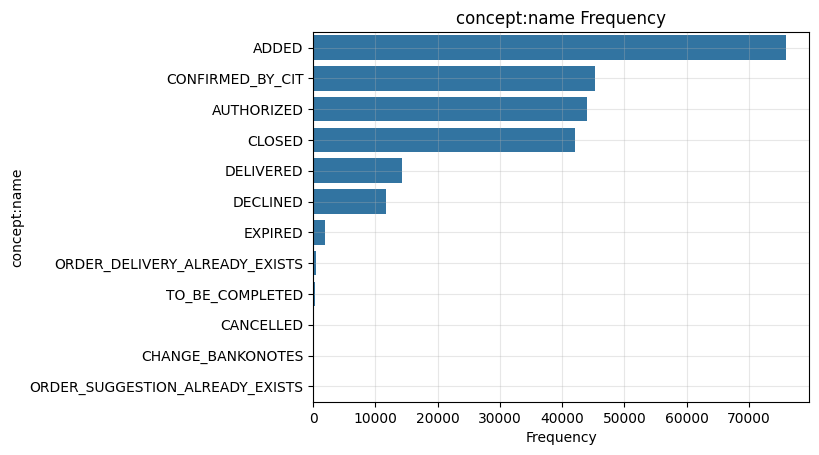

In [14]:
hist = log.groupby('concept:name').count().reset_index()[['concept:name', '@@index']]
hist.sort_values(by='@@index', ascending=False, inplace=True)
plt.title('concept:name Frequency')
sns.barplot(data=hist, y='concept:name', x='@@index')
plt.grid(True, zorder=1, alpha=0.3)
plt.xlabel('Frequency')

As observed, ADDED, CONFIRMED_BY_CIT, AUTHORIZED, and CLOSED are the most frequent activities. In fact, as discussed in the following paragraph, these represent the core states of the extracted process.

### 🔄 Evolution of System States Over Time

We know that the information systems have been receiving various software updates, and their behavior has changed over time. As a result, the states may evolve over time, considering that the system undergoes continuous updates and improvements. Therefore, it is necessary to conduct a state analysis over time, considering the impact of these updates and improvements on the system’s behavior.

In [15]:
df['year'] = df['TR_TS_CREATION'].dt.year

df2 = df.groupby(['year', 'ACTIVITY']).size().unstack().reset_index(drop=True)
df2

ACTIVITY,ADDED,AUTHORIZED,CANCELLED,CHANGE_BANKONOTES,CLOSED,CONFIRMED_BY_CIT,DECLINED,DELIVERED,EXPIRED,ORDER_DELIVERY_ALREADY_EXISTS,ORDER_SUGGESTION_ALREADY_EXISTS,TO_BE_COMPLETED
0,196.0,139.0,NaN,4.0,90.0,137.0,7.0,NaN,NaN,NaN,NaN,NaN
1,7146.0,3921.0,2.0,NaN,1787.0,4955.0,1819.0,NaN,NaN,NaN,NaN,315.0
2,29139.0,13942.0,NaN,NaN,8771.0,14345.0,6802.0,7631.0,NaN,NaN,NaN,NaN
3,36078.0,22992.0,10.0,NaN,25923.0,22880.0,2750.0,6257.0,1510.0,177.0,NaN,NaN
4,3364.0,3019.0,3.0,NaN,5544.0,3010.0,348.0,391.0,334.0,218.0,3.0,NaN


c:\Users\coral\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\coral\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\coral\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.g

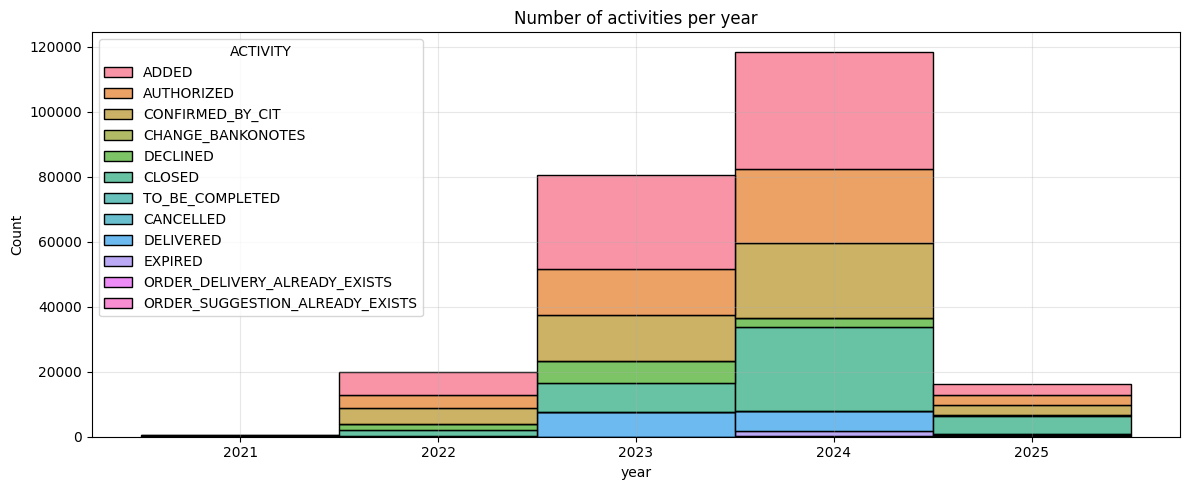

In [16]:
plt.figure(figsize=(12, 5))
plt.title("Number of activities per year")
sns.histplot(df, x='year', hue='ACTIVITY', multiple='stack', discrete=True)

plt.grid(True, zorder=1, alpha=0.3)
plt.tight_layout()
plt.show()

The previous plot illustrates the number of activities per year, taking into account a steady increase in the number of orders over time. Notably, in January 2025 alone, the number of order activities is equivalent to the total recorded throughout the entire year of 2022.
<br/>
<br/>
Next, we will analyze if during these years the number of states has been changed and if some states have been added in the following year or have been removed.

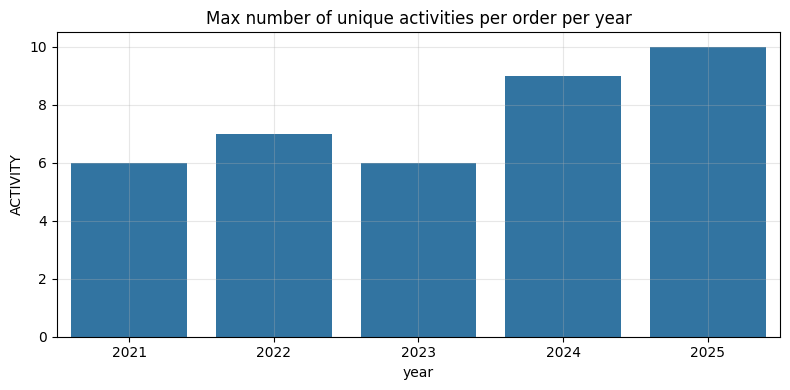

In [17]:
dfhist = df[['year', 'ACTIVITY']].drop_duplicates().groupby(by='year').count()
dfhist

plt.figure(figsize=(8, 4))
plt.title("Max number of unique activities per order per year")
sns.barplot(dfhist, x='year', y='ACTIVITY')

plt.grid(True, zorder=1, alpha=0.3)
plt.tight_layout()
plt.show()

As we can see, the number of activities has increased over the years, assuming that the system is evolving, and new states have been added during the improvement of the information system.
<br />
<br />
<br />
In the following image, we see how the percentage distribution of states changes among different years. The state CHANGE_BANKNOTES and TO_BE_COMPLETED do not appear in recent years, which could be a consequence of the elimination of these states, since the largest number of observations are found in recent years.

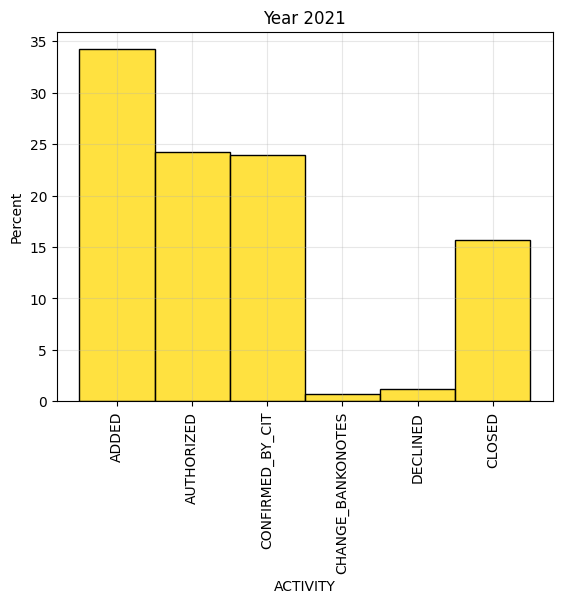

In [18]:
plt.title('Year 2021')
sns.histplot(df[df['year'] == 2021], x='ACTIVITY', stat="percent", color='gold')
plt.xticks(rotation=90)

plt.grid(True, zorder=1, alpha=0.3)
plt.show()

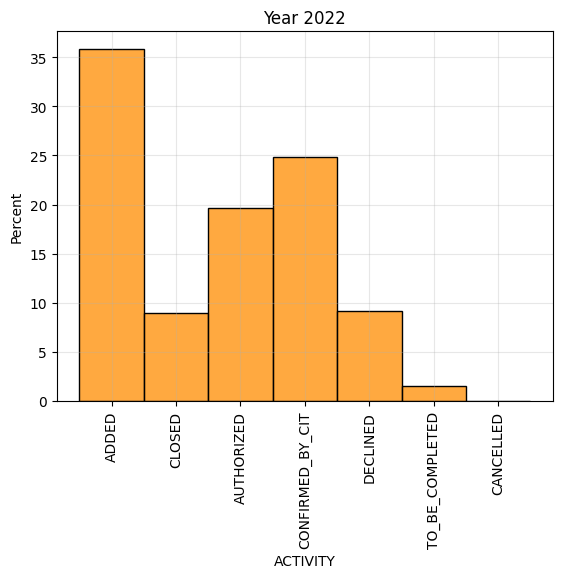

In [19]:
plt.title('Year 2022')
sns.histplot(df[df['year'] == 2022], x='ACTIVITY', stat="percent", color='darkorange')
plt.xticks(rotation=90)

plt.grid(True, zorder=1, alpha=0.3)
plt.show()

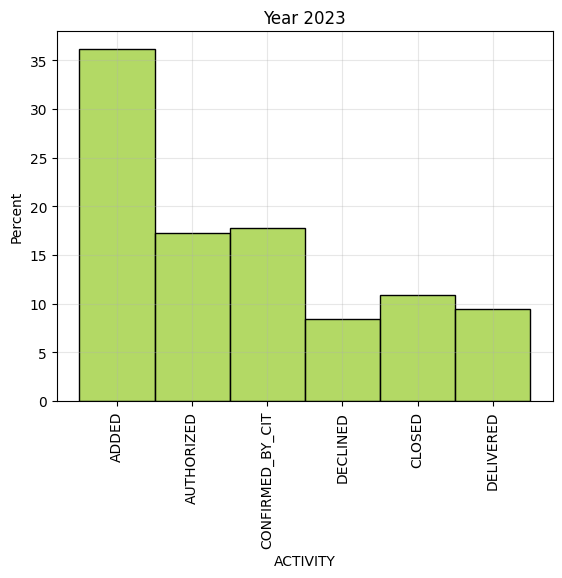

In [20]:
plt.title('Year 2023')
sns.histplot(df[df['year'] == 2023], x='ACTIVITY', stat="percent", color='yellowgreen')
plt.xticks(rotation=90)

plt.grid(True, zorder=1, alpha=0.3)
plt.show()

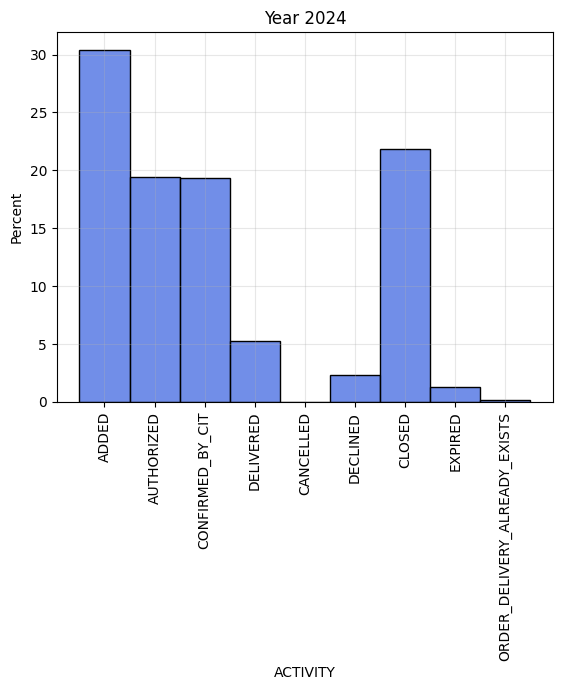

In [21]:
plt.title('Year 2024')
sns.histplot(df[df['year'] == 2024], x='ACTIVITY', stat="percent", color='royalblue')
plt.xticks(rotation=90)

plt.grid(True, zorder=1, alpha=0.3)
plt.show()

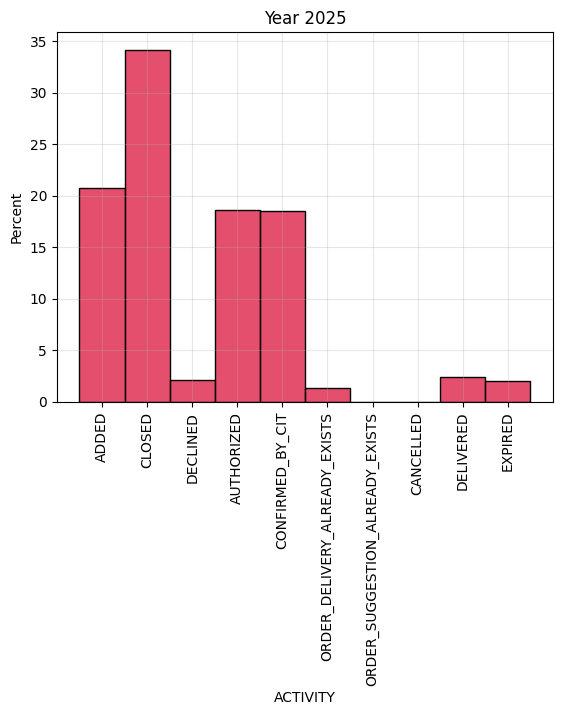

In [22]:
plt.title('Year 2025')
sns.histplot(df[df['year'] == 2025], x='ACTIVITY', stat="percent", color='crimson')
plt.xticks(rotation=90)

plt.grid(True, zorder=1, alpha=0.3)
plt.show()

Next, we will analyze the start state and the end state of each event.

In [23]:
log_2024 = filter_traces_contained(log, pd.Timestamp('2024-01-01'), pd.Timestamp('2024-12-31'))
log_2025 = filter_traces_contained(log, pd.Timestamp('2025-01-01'), pd.Timestamp('2025-12-31'))

start_activities = pm4py.get_start_activities(log)
end_activities = pm4py.get_end_activities(log)
start_activities_2024 = pm4py.get_start_activities(log_2024)
end_activities_2024 = pm4py.get_end_activities(log_2024)
start_activities_2025 = pm4py.get_start_activities(log_2025)
end_activities_2025 = pm4py.get_end_activities(log_2025)

c:\Users\coral\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\coral\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\coral\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.g

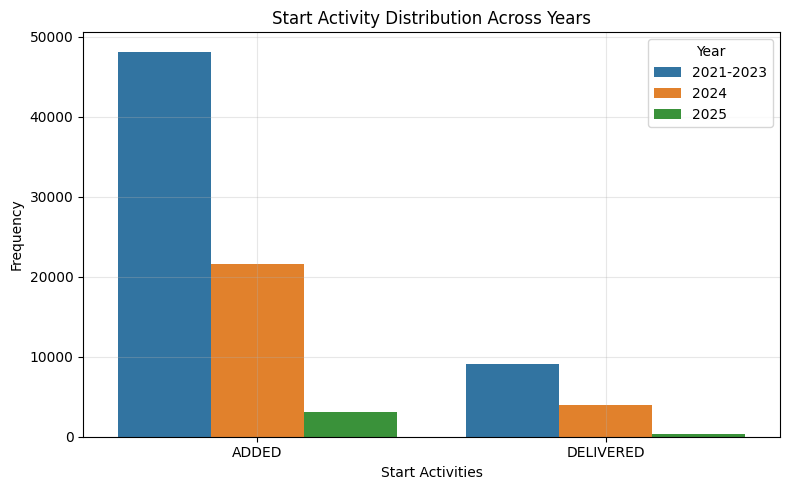

In [24]:
start_activities_df = pd.DataFrame({
    "Activity": list(start_activities.keys()) * 3,
    "Frequency": list(start_activities.values()) + list(start_activities_2024.values()) + list(start_activities_2025.values()),
    "Year": ["2021-2023"] * len(start_activities) + ["2024"] * len(start_activities_2024) + ["2025"] * len(start_activities_2025)
})

# Create grouped bar plot
plt.figure(figsize=(8, 5))
sns.barplot(x="Activity", y="Frequency", hue="Year", data=start_activities_df)

# Labels and title
plt.xlabel("Start Activities")
plt.ylabel("Frequency")
plt.title("Start Activity Distribution Across Years")

plt.grid(True, zorder=1, alpha=0.3)
plt.tight_layout()
plt.show()

The distribution of start state is equal to only two states, such as ‘ADDED’ and ‘DELIVERED’ and are the only states which starts an event among years, assuming that they does not change over time.

In [25]:
all_end_activities = set(end_activities.keys()) | set(end_activities_2024.keys()) | set(end_activities_2025.keys())

# Step 2: Fill missing activities with 0
end_activities = {k: end_activities.get(k, 0) for k in all_end_activities}
end_activities_2024 = {k: end_activities_2024.get(k, 0) for k in all_end_activities}
end_activities_2025 = {k: end_activities_2025.get(k, 0) for k in all_end_activities}

end_activities_df = pd.DataFrame({
    "Activity": list(end_activities.keys()) * 3,
    "Frequency": list(end_activities.values()) + list(end_activities_2024.values()) + list(end_activities_2025.values()),
    "Year": [" < 2023"] * len(end_activities) + ["2024"] * len(end_activities_2024) + ["2025"] * len(end_activities_2025)
})

The same cannot be said for the end activities, as they vary across each selected year. It is interesting to note that, despite the increasing number of states over the years, the number of end activities has been decreasing. This suggests that the system is improving its management of the order lifecycle.

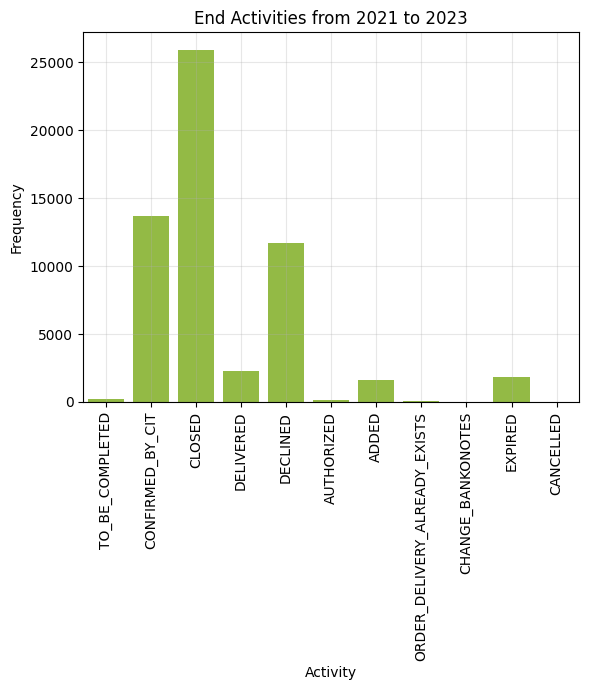

In [26]:
hist = end_activities_df[(end_activities_df['Year'] == ' < 2023') & (end_activities_df['Frequency'] > 1)]
plt.title('End Activities from 2021 to 2023')
sns.barplot(x="Activity", y="Frequency", data=hist, color='yellowgreen')
plt.xticks(rotation=90)

plt.grid(True, zorder=1, alpha=0.3)
plt.show()

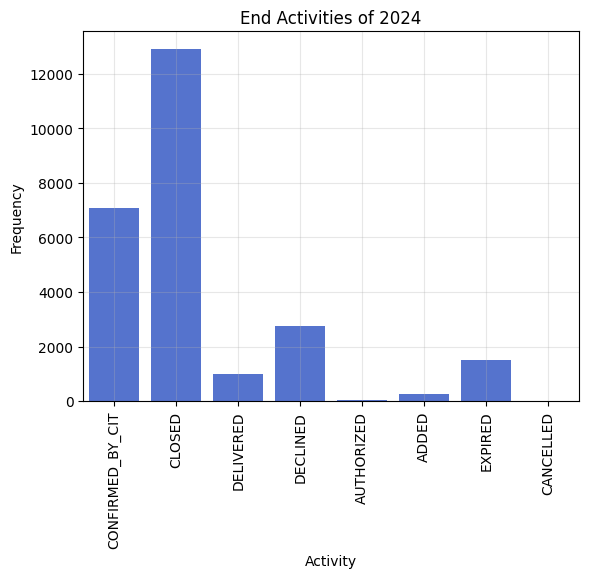

In [27]:
hist = end_activities_df[(end_activities_df['Year'] == '2024') & (end_activities_df['Frequency'] > 1)]
plt.title('End Activities of 2024')
sns.barplot(x="Activity", y="Frequency", data=hist, color='royalblue')
plt.xticks(rotation=90)

plt.grid(True, zorder=1, alpha=0.3)
plt.show()

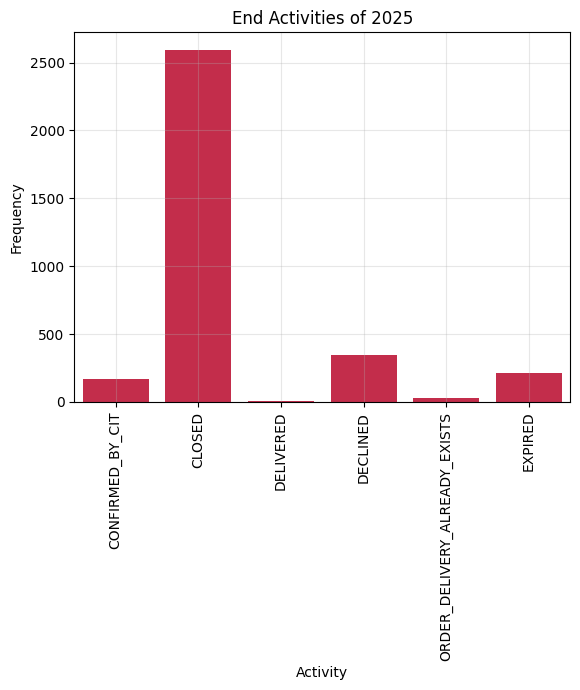

In [28]:
hist = end_activities_df[(end_activities_df['Year'] == '2025') & (end_activities_df['Frequency'] > 1)]
plt.title('End Activities of 2025')
sns.barplot(x="Activity", y="Frequency", data=hist, color='crimson')
plt.xticks(rotation=90)
plt.grid(True, zorder=1, alpha=0.3)
plt.show()

### 🧼 Data Cleaning
Due to the continuous evolution of information systems and the modifications in the order management process states, it is necessary to filter data related to irrelevant and process states.
<br/>
Therefore, three combinations of the starting dataset will be analyzed and next evaluated with the process discovery algorithms and evaluation metrics.

In [29]:
filtered_log1 = pm4py.filter_trace_attribute_values(log, 'concept:name', {'CANCELLED', 'ORDER_DELIVERY_ALREADY_EXISTS', 'ORDER_SUGGESTION_ALREADY_EXISTS', 'TO_BE_COMPLETED', 'CHANGE_BANKONOTES'}, retain=False)
filtered_log2 = pm4py.filter_time_range(log, pd.Timestamp('2024-10-01'), pd.Timestamp('2025-01-31'))
filtered_log3 = pm4py.filter_time_range(filtered_log1, pd.Timestamp('2024-10-01'), pd.Timestamp('2025-01-31'))
filtered_log3


,TR_TS_CREATION,BRANCH_ORDER_ID,ACTIVITY,case:concept:name,concept:name,time:timestamp,@@index,@@case_index
182336,2024-10-07 00:00:00+00:00,56092,DELIVERED,56092,DELIVERED,2024-10-07 00:00:00+00:00,182336,45772
182337,2024-10-08 14:01:05.015000+00:00,56092,EXPIRED,56092,EXPIRED,2024-10-08 14:01:05.015000+00:00,182337,45772
182729,2024-10-02 13:19:10.493333300+00:00,56184,CLOSED,56184,CLOSED,2024-10-02 13:19:10.493333300+00:00,182729,45862
182730,2024-10-02 13:19:10.495000+00:00,56184,CLOSED,56184,CLOSED,2024-10-02 13:19:10.495000+00:00,182730,45862
182734,2024-10-07 14:29:47.859000+00:00,56185,CLOSED,56185,CLOSED,2024-10-07 14:29:47.859000+00:00,182734,45863
...,...,...,...,...,...,...,...,...
231549,2025-01-31 00:00:00+00:00,66596,DELIVERED,66596,DELIVERED,2025-01-31 00:00:00+00:00,231549,56276
231638,2025-01-31 00:00:00+00:00,66612,DELIVERED,66612,DELIVERED,2025-01-31 00:00:00+00:00,231638,56292
231653,2025-01-31 00:00:00+00:00,66615,DELIVERED,66615,DELIVERED,2025-01-31 00:00:00+00:00,231653,56295
231668,2025-01-31 00:00:00+00:00,66618,DELIVERED,66618,DELIVERED,2025-01-31 00:00:00+00:00,231668,56298


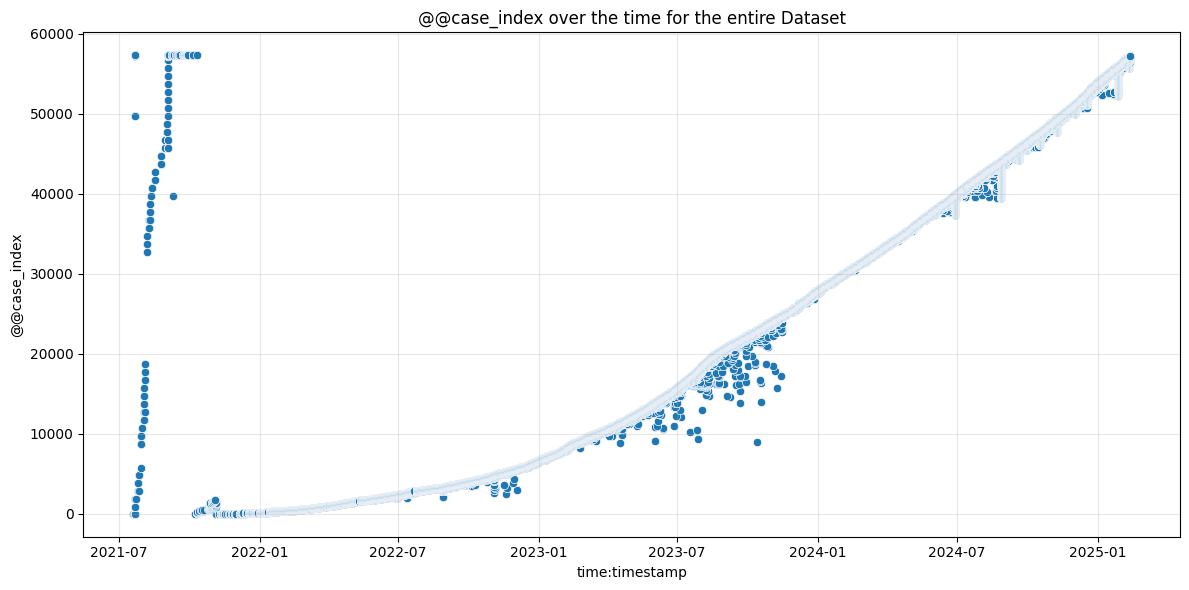

In [30]:
plt.figure(figsize=(12, 6))
plt.title('@@case_index over the time for the entire Dataset')
sns.scatterplot(data=log, x="time:timestamp", y="@@case_index")

plt.grid(True, zorder=1, alpha=0.3)
plt.tight_layout()
plt.show()


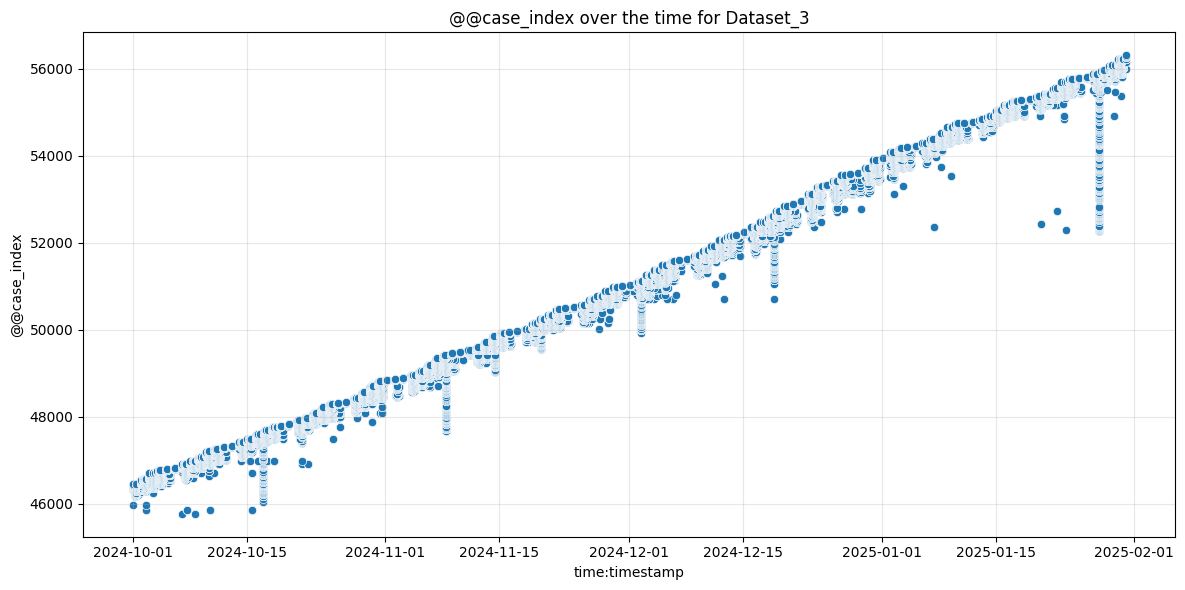

In [31]:
plt.figure(figsize=(12, 6))
plt.title('@@case_index over the time for Dataset_3')
sns.scatterplot(data=filtered_log3, x="time:timestamp", y="@@case_index")

plt.grid(True, zorder=1, alpha=0.3)
plt.tight_layout()
plt.show()

As observed, we are comparing the dataset without filtering to the one with both filters applied. In the unfiltered dataset, we can observe anomalous behavior in the early part of history, which may indicate that the system was either newly created or composed of various inconsistencies.

Text(0.5, 0, 'Frequency')

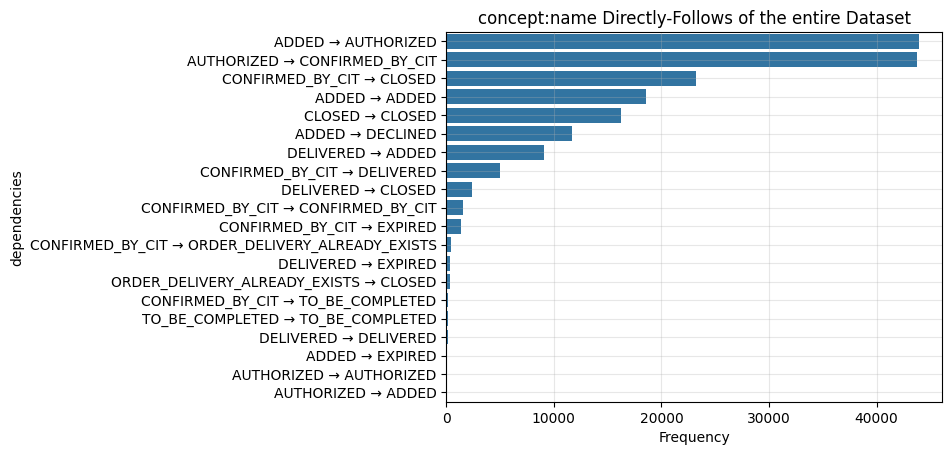

In [32]:
# Create an empty list to store the resulting DataFrames
result_frames = []

rel = log.copy()[['BRANCH_ORDER_ID', '@@index', '@@case_index', 'case:concept:name', 'concept:name', 'time:timestamp']]

# Group by the case index
for case_index, group in rel.groupby('@@case_index'):
    # Sort the group by timestamp to ensure proper order
    group = group.sort_values(by='time:timestamp')
    
    # Shift the 'concept:name' column to get the next activity
    group['next_activity'] = group['concept:name'].shift(-1)
    
    # Append the group with the new 'next_activity' column to the result list
    result_frames.append(group)

rel = pd.concat(result_frames)
rel = rel.reset_index(drop=True)

rel['relation'] = rel['concept:name'] + ' → ' + rel['next_activity']
rel = rel[['BRANCH_ORDER_ID', '@@index', 'relation']].drop_duplicates()
rel = rel[rel['relation'].notna()]

rel_hist = rel.groupby('relation').count().sort_values(by='@@index', ascending=False).head(20)
rel_hist = rel_hist[rel_hist['@@index'] >= 10]

plt.title('concept:name Directly-Follows of the entire Dataset')
sns.barplot(data=rel_hist, y='relation', x='@@index')
plt.grid(True, zorder=1, alpha=0.3)
plt.ylabel('dependencies')
plt.xlabel('Frequency')

Text(0.5, 0, 'Frequency')

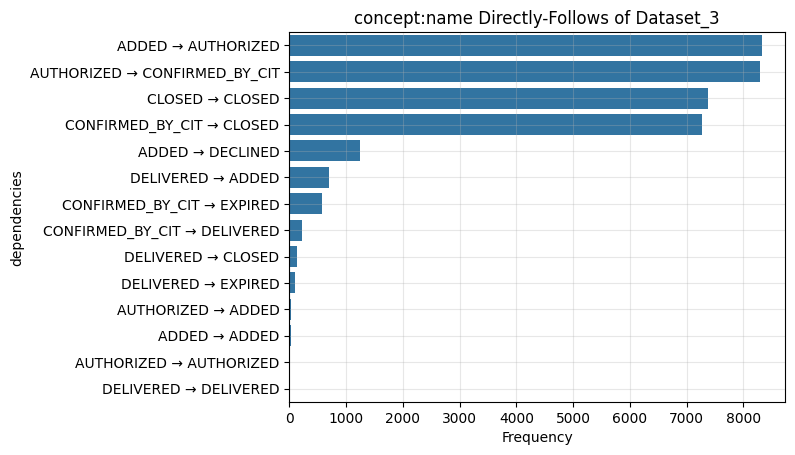

In [33]:
# Create an empty list to store the resulting DataFrames
result_frames = []

rel = filtered_log3.copy()[['BRANCH_ORDER_ID', '@@index', '@@case_index', 'case:concept:name', 'concept:name', 'time:timestamp']]

# Group by the case index
for case_index, group in rel.groupby('@@case_index'):
    # Sort the group by timestamp to ensure proper order
    group = group.sort_values(by='time:timestamp')
    
    # Shift the 'concept:name' column to get the next activity
    group['next_activity'] = group['concept:name'].shift(-1)
    
    # Append the group with the new 'next_activity' column to the result list
    result_frames.append(group)

rel = pd.concat(result_frames)
rel = rel.reset_index(drop=True)

rel['relation'] = rel['concept:name'] + ' → ' + rel['next_activity']
rel = rel[['BRANCH_ORDER_ID', '@@index', 'relation']].drop_duplicates()
rel = rel[rel['relation'].notna()]

rel_hist = rel.groupby('relation').count().sort_values(by='@@index', ascending=False).head(20)
rel_hist = rel_hist[rel_hist['@@index'] >= 10]

plt.title('concept:name Directly-Follows of Dataset_3')
sns.barplot(data=rel_hist, y='relation', x='@@index')
plt.grid(True, zorder=1, alpha=0.3)
plt.ylabel('dependencies')
plt.xlabel('Frequency')

In the unfiltered dataset, the direct dependencies are much more distributed across different states, and there are numerous self-loops due to noise within the data. In the filtered dataset, this issue is mitigated, although some self-loops still remain. The presence of self-loops should not occur, as only state transitions within the information system are tracked.

### 📜 Process Discovery

Process discovery aims to extract processes that closely align with the data, particularly the event log. As mentioned earlier, we will apply a specific approach, resulting in the generation of a Petri net model, which is the ‘Play in’. Subsequently, various metrics will be calculated to evaluate the performance of the discovered process across different algorithms.
<br/>
<br/>
We will use:
- Alpha and Alpha Plus Miner;
- Heuristic Miner;
- Inductive Mining;

For the evaluation metrics we will use:
- Fitness;
- Precision;
- Generalization;
- Simplicity;

In [29]:
def evaluate(log, net, im, fm):
    fitness = pm4py.fitness_token_based_replay(log, net, im, fm).get('average_trace_fitness')
    precision = precision_evaluator.apply(log, net, im, fm)
    generalization = generalization_evaluator.apply(log, net, im, fm)
    simplicity = simplicity_evaluator.apply(net)
    return fitness, precision, generalization, simplicity


def experiment(datasets, thresholds):
    
    results = pd.DataFrame()
    for d in datasets:        
        # Alpha Algorithm
        net, im, fm = pm4py.discover_petri_net_alpha(d.get('data'))
        row = pd.DataFrame(data={'config': ['A('+d.get('name')+')']})
        row[['Fitness', 'Precision', 'Generalization', 'Simplicity']] = evaluate(d.get('data'), net, im, fm)
        results = pd.concat([results, row], ignore_index=True)
        
        # Alpha+ Algorithm
        net, im, fm = pm4py.discover_petri_net_alpha_plus(d.get('data'))
        row = pd.DataFrame(data={'config': ['A+('+d.get('name')+')']})
        row[['Fitness', 'Precision', 'Generalization', 'Simplicity']] = evaluate(d.get('data'), net, im, fm)
        results = pd.concat([results, row], ignore_index=True)
        
                
        for t in thresholds:
            
            # Heuristics Miner
            heu = heuristics_miner.apply_heu(d.get('data'), parameters={heuristics_miner.Variants.CLASSIC.value.Parameters.DEPENDENCY_THRESH: t})
            net, im, fm = pm4py.convert_to_petri_net(heu)
            row = pd.DataFrame(data={'config': ['HM('+d.get('name')+', '+str(t)+')']})
            row[['Fitness', 'Precision', 'Generalization', 'Simplicity']] = evaluate(d.get('data'), net, im, fm)
            results = pd.concat([results, row], ignore_index=True)
            
            # Inductive Miner
            net, im, fm = pm4py.discover_petri_net_inductive(d.get('data'), t)
            row = pd.DataFrame(data={'config': ['IM('+d.get('name')+', '+str(t)+')']})
            row[['Fitness', 'Precision', 'Generalization', 'Simplicity']] = evaluate(d.get('data'), net, im, fm)
            results = pd.concat([results, row], ignore_index=True)
            
            
    return results

In [33]:
datasets_experiment = [
    {'name': 'D0', 'data': log},
    {'name': 'D1', 'data': filtered_log1},
    {'name': 'D2', 'data': filtered_log2},
    {'name': 'D3', 'data': filtered_log3}
]

experiment_df = experiment(datasets_experiment, [0.5, 0.8])
experiment_df

replaying log with TBR, completed traces ::   0%|          | 0/209 [00:00<?, ?it/s]

computing precision with alignments, completed variants ::   0%|          | 0/206 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/209 [00:00<?, ?it/s]

C:\Users\coral\AppData\Local\Temp\ipykernel_22860\1077204211.py:20: DeprecatedWarning: discover_petri_net_alpha_plus is deprecated as of 2.3.0 and will be removed in 3.0.0. This method will be removed in a future release.
  net, im, fm = pm4py.discover_petri_net_alpha_plus(d.get('data'))


replaying log with TBR, completed traces ::   0%|          | 0/209 [00:00<?, ?it/s]

computing precision with alignments, completed variants ::   0%|          | 0/206 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/209 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/209 [00:00<?, ?it/s]

computing precision with alignments, completed variants ::   0%|          | 0/206 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/209 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/209 [00:00<?, ?it/s]

computing precision with alignments, completed variants ::   0%|          | 0/206 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/209 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/209 [00:00<?, ?it/s]

computing precision with alignments, completed variants ::   0%|          | 0/206 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/209 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/209 [00:00<?, ?it/s]

computing precision with alignments, completed variants ::   0%|          | 0/206 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/209 [00:00<?, ?it/s]

c:\Users\coral\AppData\Local\Programs\Python\Python310\lib\site-packages\pm4py\algo\discovery\dfg\adapters\pandas\df_statistics.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[start_timestamp_key] = df[timestamp_key]


replaying log with TBR, completed traces ::   0%|          | 0/154 [00:00<?, ?it/s]

computing precision with alignments, completed variants ::   0%|          | 0/152 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/154 [00:00<?, ?it/s]

C:\Users\coral\AppData\Local\Temp\ipykernel_22860\1077204211.py:20: DeprecatedWarning: discover_petri_net_alpha_plus is deprecated as of 2.3.0 and will be removed in 3.0.0. This method will be removed in a future release.
  net, im, fm = pm4py.discover_petri_net_alpha_plus(d.get('data'))


replaying log with TBR, completed traces ::   0%|          | 0/154 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/152 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/154 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/154 [00:00<?, ?it/s]

computing precision with alignments, completed variants ::   0%|          | 0/152 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/154 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/154 [00:00<?, ?it/s]

computing precision with alignments, completed variants ::   0%|          | 0/152 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/154 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/154 [00:00<?, ?it/s]

computing precision with alignments, completed variants ::   0%|          | 0/152 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/154 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/154 [00:00<?, ?it/s]

computing precision with alignments, completed variants ::   0%|          | 0/152 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/154 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/59 [00:00<?, ?it/s]

computing precision with alignments, completed variants ::   0%|          | 0/103 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/59 [00:00<?, ?it/s]

C:\Users\coral\AppData\Local\Temp\ipykernel_22860\1077204211.py:20: DeprecatedWarning: discover_petri_net_alpha_plus is deprecated as of 2.3.0 and will be removed in 3.0.0. This method will be removed in a future release.
  net, im, fm = pm4py.discover_petri_net_alpha_plus(d.get('data'))


replaying log with TBR, completed traces ::   0%|          | 0/59 [00:00<?, ?it/s]

computing precision with alignments, completed variants ::   0%|          | 0/103 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/59 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/59 [00:00<?, ?it/s]

computing precision with alignments, completed variants ::   0%|          | 0/103 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/59 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/59 [00:00<?, ?it/s]

computing precision with alignments, completed variants ::   0%|          | 0/103 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/59 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/59 [00:00<?, ?it/s]

computing precision with alignments, completed variants ::   0%|          | 0/103 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/59 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/59 [00:00<?, ?it/s]

computing precision with alignments, completed variants ::   0%|          | 0/103 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/59 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/40 [00:00<?, ?it/s]

computing precision with alignments, completed variants ::   0%|          | 0/76 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/40 [00:00<?, ?it/s]

C:\Users\coral\AppData\Local\Temp\ipykernel_22860\1077204211.py:20: DeprecatedWarning: discover_petri_net_alpha_plus is deprecated as of 2.3.0 and will be removed in 3.0.0. This method will be removed in a future release.
  net, im, fm = pm4py.discover_petri_net_alpha_plus(d.get('data'))


replaying log with TBR, completed traces ::   0%|          | 0/40 [00:00<?, ?it/s]

computing precision with alignments, completed variants ::   0%|          | 0/76 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/40 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/40 [00:00<?, ?it/s]

computing precision with alignments, completed variants ::   0%|          | 0/76 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/40 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/40 [00:00<?, ?it/s]

computing precision with alignments, completed variants ::   0%|          | 0/76 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/40 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/40 [00:00<?, ?it/s]

computing precision with alignments, completed variants ::   0%|          | 0/76 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/40 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/40 [00:00<?, ?it/s]

computing precision with alignments, completed variants ::   0%|          | 0/76 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/40 [00:00<?, ?it/s]

,config,Fitness,Precision,Generalization,Simplicity
0,A(D0),0.646543,0.354892,0.874911,1.000000
1,A+(D0),0.345804,0.359146,0.867229,0.806452
2,"HM(D0, 0.5)",0.956827,0.760051,0.788418,0.525424
3,"IM(D0, 0.5)",1.000000,0.404484,0.931041,0.647059
4,"HM(D0, 0.8)",0.956814,0.778656,0.830946,0.557692
5,"IM(D0, 0.8)",1.000000,0.404484,0.931041,0.647059
6,A(D1),0.646987,0.473205,0.991529,1.000000
7,A+(D1),0.075554,0.000000,0.991529,1.000000
8,"HM(D1, 0.5)",0.952900,0.814668,0.929148,0.580645
9,"IM(D1, 0.5)",1.000000,0.590931,0.970582,0.681818


In [ ]:
experiment_df.to_csv('./data/experiment_results.csv', sep=';', index=False)

As observed, the best algorithm for our dataset is Heuristic Mining, with a robustness threshold of 0.5, applied to Dataset3. This dataset corresponds to the filter applied to states removed with frequencies close to zero, including only records from the last month. In general, we can observe that Heuristic Miner performs better than both Inductive Miner and the Alpha Mining algorithm.

In [3]:
experiment_df = pd.read_csv('./data/experiment_results.csv', sep=';')

experiment_df['mean'] = experiment_df[['Fitness', 'Precision', 'Generalization', 'Simplicity']].mean(axis=1)
experiment_df = experiment_df.sort_values(by='mean', ascending=False)
experiment_df.drop(columns='mean', inplace=True)

experiment_df.rename(columns={'config': 'experiment'}, inplace=True)
experiment_df.set_index('experiment', inplace=True)
experiment_df


,Fitness,Precision,Generalization,Simplicity
experiment,,,,
"HM(D3, 0.5)",0.999414,0.990967,0.943469,0.615385
"HM(D3, 0.8)",0.999414,0.990967,0.943469,0.615385
"HM(D2, 0.8)",0.999377,0.984736,0.843825,0.600000
"HM(D2, 0.5)",0.999383,0.978452,0.806619,0.581395
"HM(D1, 0.8)",0.952900,0.814668,0.929148,0.580645
"HM(D1, 0.5)",0.952900,0.814668,0.929148,0.580645
"IM(D1, 0.5)",1.000000,0.590931,0.970582,0.681818
"IM(D1, 0.8)",1.000000,0.590931,0.970582,0.681818
"IM(D3, 0.5)",1.000000,0.578079,0.915842,0.659574


The color of the heatmap ranges from red to green, with green representing the best scores. As observed, fitness and precision tend to increase approximately linearly toward the best-performing model. Generalization consistently maintains a high score. Finally, for simplicity, we obtain an average score of approximately 0.60, with the best-scoring algorithms which exhibit the lowest fitness and precision. This is because high simplicity implies overly simplistic models that do not adequately fit the data.

<Axes: ylabel='experiment'>

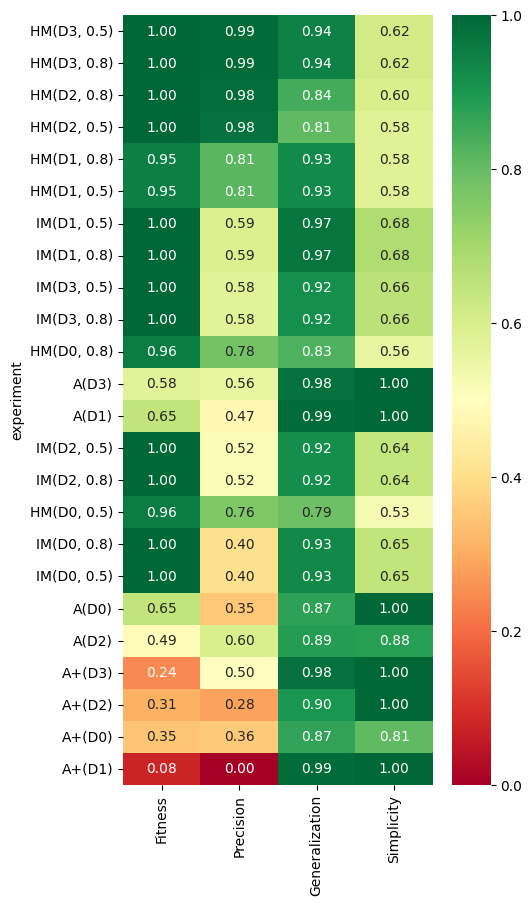

In [36]:
plt.figure(figsize=(5, 10))
sns.heatmap(experiment_df, cmap='RdYlGn', annot=True, fmt='.2f')

In the following image we will show the Petri net modeled by the Heuristic Miner algorithm.

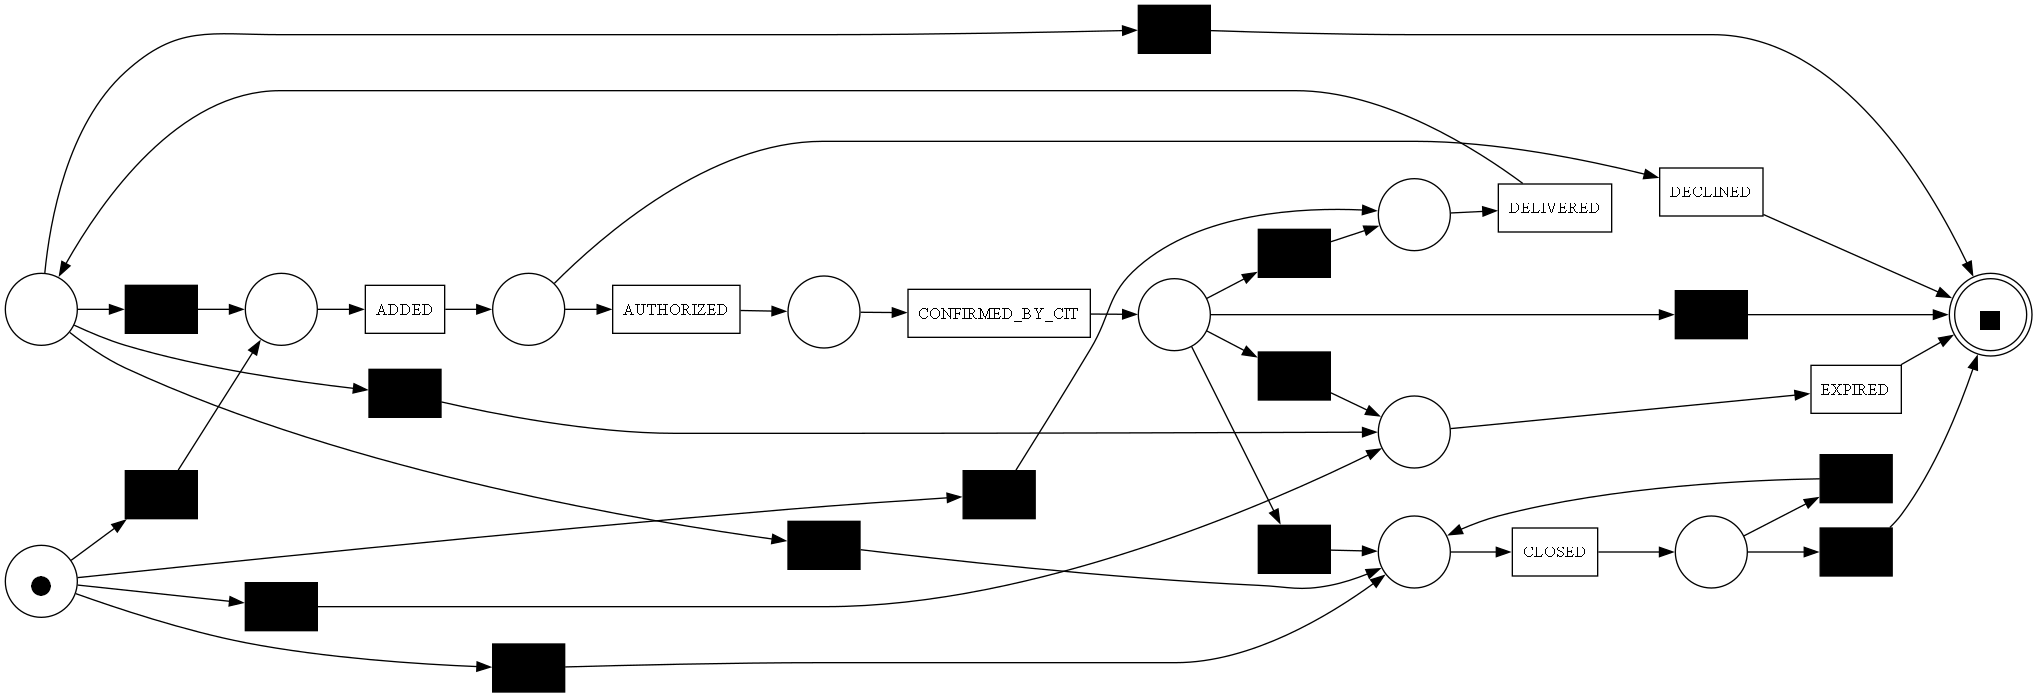

In [34]:
heu = heuristics_miner.apply_heu(filtered_log3, parameters={heuristics_miner.Variants.CLASSIC.value.Parameters.DEPENDENCY_THRESH: 0.5})
net, im, fm = pm4py.convert_to_petri_net(heu)
pm4py.view_petri_net(net, im, fm)

{intplace_ADDED,
 intplace_CLOSED,
 intplace_CONFIRMED_BY_CIT,
 intplace_DELIVERED,
 pre_ADDED,
 pre_CLOSED,
 pre_CONFIRMED_BY_CIT,
 pre_DELIVERED,
 pre_EXPIRED,
 sink0,
 source0}

In [56]:
# Properties
places = net.places
transitions = net.transitions

print("Analyisis:\n")
result =  woflan.apply(net, im, fm)

table = PrettyTable()

# Set column names
table.field_names = ["Property", "Value"]

# Add rows with the property names and corresponding values
table.add_row(["Places", len(places)])  # Number of places
table.add_row(["Transitions", len(transitions)])  # Number of transitions

print(table)


Analyisis:

Input is ok.
Petri Net is a workflow net.
Every place is covered by s-components.
There are no dead tasks.
All tasks are live.
+-------------+-------+
|   Property  | Value |
+-------------+-------+
|    Places   |   11  |
| Transitions |   21  |
+-------------+-------+


As observed, the first transition can be either DELIVERED or ADDED as the initial step in order creation. Following the ADDED path, we obtain a clear representation of the system’s behavior. Specifically, the order can be authorized by a technical operator and subsequently confirmed by the CIT delivery agency. During the confirmation process, the order can transition into various states, such as DELIVERED or CLOSED for the successful path, or it may expire. Both the expiration and closing states can also be reached from the DELIVERED transition. If the order is not authorized, it transitions to DECLINED, and the process ends.
<br/>
<br/>
Next, we will analyze the network created by the Heuristic Miner algorithm.

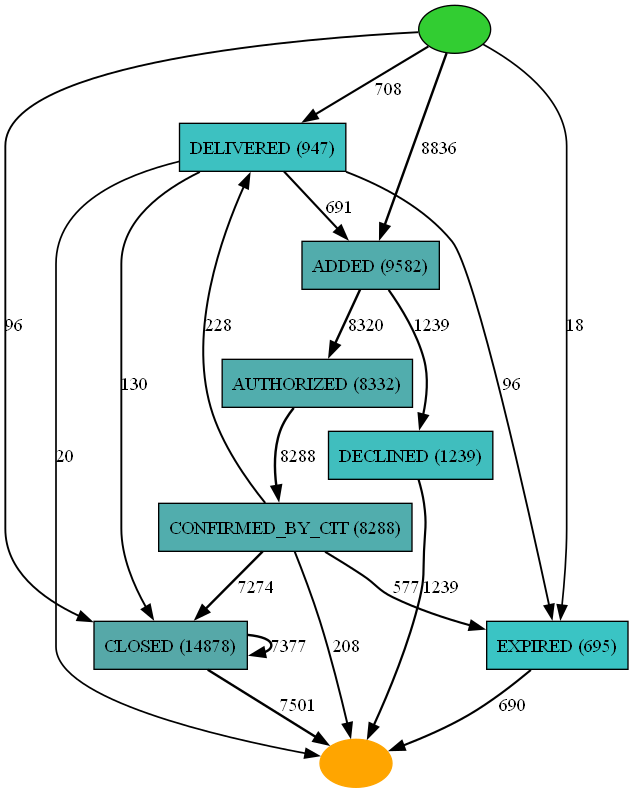

In [40]:
pm4py.view_heuristics_net(heu)

For completeness, the best processes obtained by the other algorithms were also plotted.

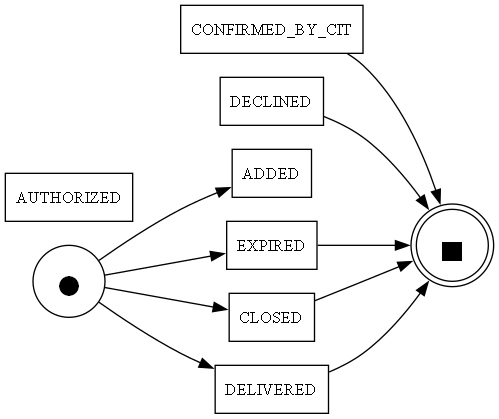

In [41]:
net_alpha, im_alpha, fm_alpha = pm4py.discover_petri_net_alpha(filtered_log3)
pm4py.view_petri_net(net_alpha, im_alpha, fm_alpha)

C:\Users\coral\AppData\Local\Temp\ipykernel_16428\2504120142.py:1: DeprecatedWarning: discover_petri_net_alpha_plus is deprecated as of 2.3.0 and will be removed in 3.0.0. This method will be removed in a future release.
  net_alpha_plus, im_alpha_plus, fm_alpha_plus = pm4py.discover_petri_net_alpha_plus(filtered_log3)


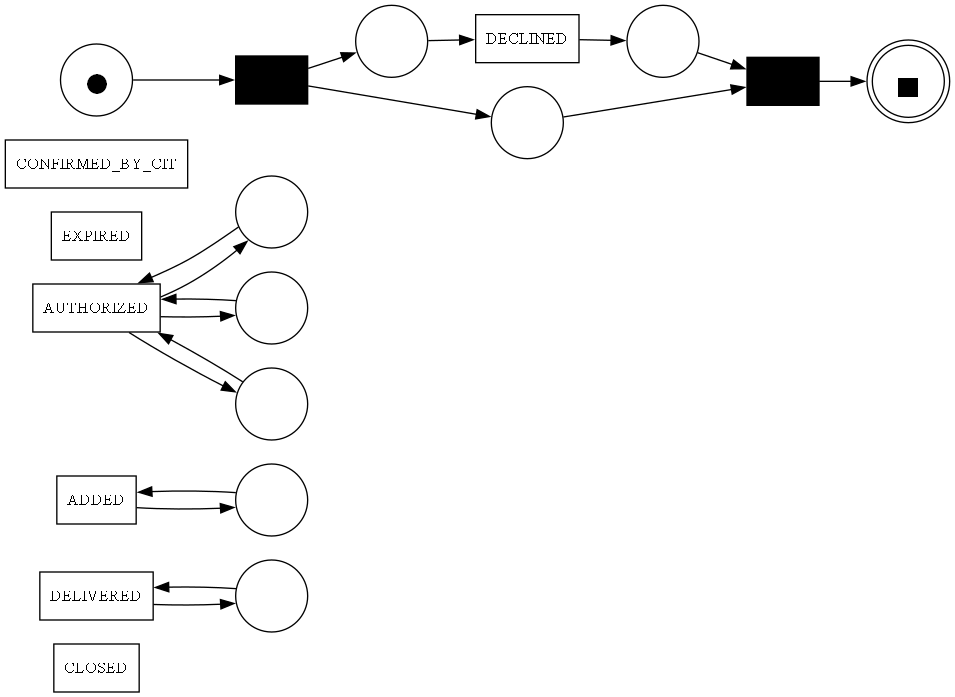

In [42]:
net_alpha_plus, im_alpha_plus, fm_alpha_plus = pm4py.discover_petri_net_alpha_plus(filtered_log3)
pm4py.view_petri_net(net_alpha_plus, im_alpha_plus, fm_alpha_plus)

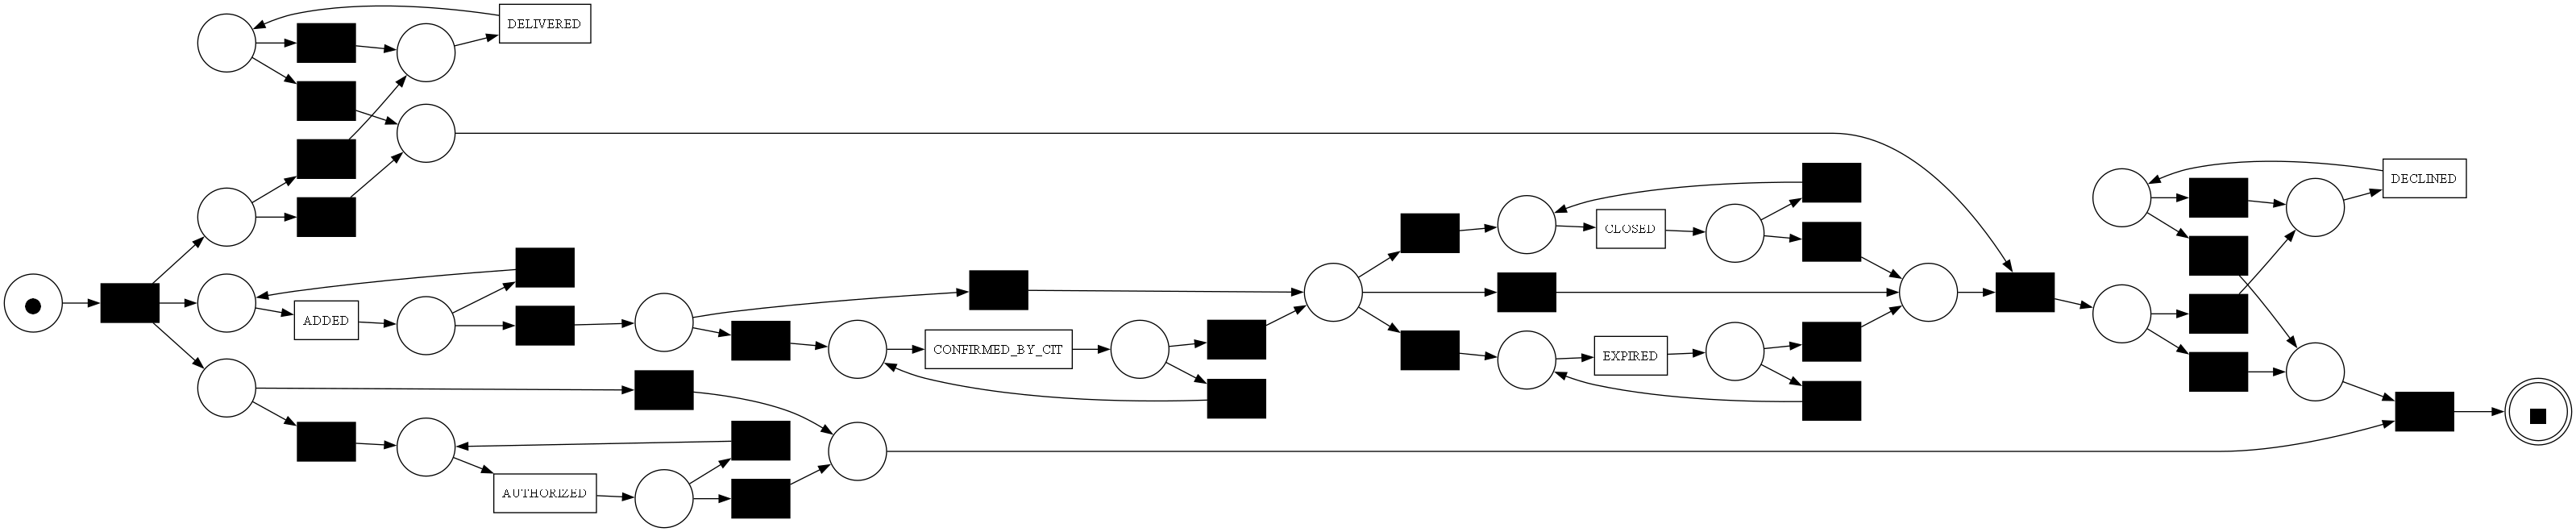

In [44]:
net_inductive, im_inductive, fm_inductive = pm4py.discover_petri_net_inductive(filtered_log1, 0.5)
pm4py.view_petri_net(net_inductive, im_inductive, fm_inductive)

### 🤖 LLM as a Process Expert Intermediate

In [46]:
print(pm4py.llm.abstract_petri_net(net, im, fm))



If I have a Petri net:

places: [ intplace_ADDED, intplace_CLOSED, intplace_CONFIRMED_BY_CIT, intplace_DELIVERED, pre_ADDED, pre_CLOSED, pre_CONFIRMED_BY_CIT, pre_DELIVERED, pre_EXPIRED, sink0, source0 ]
transitions: [ (ADDED, 'ADDED'), (AUTHORIZED, 'AUTHORIZED'), (CLOSED, 'CLOSED'), (CONFIRMED_BY_CIT, 'CONFIRMED_BY_CIT'), (DECLINED, 'DECLINED'), (DELIVERED, 'DELIVERED'), (EXPIRED, 'EXPIRED'), (hid_11, None), (hid_12, None), (hid_13, None), (hid_14, None), (hid_15, None), (hid_16, None), (hid_17, None), (hid_2, None), (hid_20, None), (hid_21, None), (hid_22, None), (hid_23, None), (hid_5, None), (hid_9, None) ]
arcs: [ (ADDED, 'ADDED')->intplace_ADDED, (AUTHORIZED, 'AUTHORIZED')->pre_CONFIRMED_BY_CIT, (CLOSED, 'CLOSED')->intplace_CLOSED, (CONFIRMED_BY_CIT, 'CONFIRMED_BY_CIT')->intplace_CONFIRMED_BY_CIT, (DECLINED, 'DECLINED')->sink0, (DELIVERED, 'DELIVERED')->intplace_DELIVERED, (EXPIRED, 'EXPIRED')->sink0, (hid_11, None)->pre_ADDED, (hid_12, None)->pre_ADDED, (hid_13, None)->pre_CLO